In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Minimum Image convention

2.0


4982.085085479659

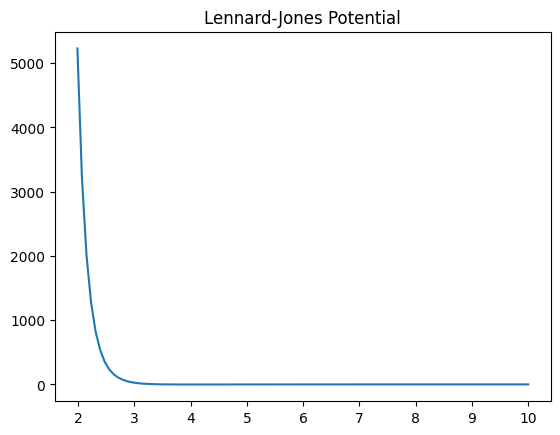

In [ ]:
L = 12 # A
r1 = np.array([1.,1.,1.]) # A
r2 = np.array([1.,1.,11.]) # A
r3 = np.array([11.,11.,11.]) # A

def difference_vector_minimum_image(ri_in, rj_in):
    ri = ri_in.copy()
    rj = rj_in.copy()

    for i in range(3):
        if ri[i] - rj[i] > L / 2:
            rj[i] += L
        elif ri[i] - rj[i] < -L / 2:
            rj[i] -= L
    return rj - ri


def distance(ri, rj):
    return np.sqrt(np.sum((ri - rj) ** 2))

r1_minimum_image = r1 + difference_vector_minimum_image(r1, r1)
r2_minimum_image = r1 + difference_vector_minimum_image(r1, r2)
r3_minimum_image = r1 + difference_vector_minimum_image(r1, r3)

center_of_mass_minimum_image = (r1_minimum_image + r2_minimum_image + r3_minimum_image) / 3

center_of_mass_minimum_image

epsilon = 162.8 # K
sigma = 3.627 # A
kB = 1.38e-23

def lennardjonespotential(ri, rj):
    r = distance(ri, rj)
    if r < 1e-10:
        return 0.0
    return 4 * ((sigma / r) ** 12 - (sigma / r) ** 6)

print(distance(r1, r2_minimum_image))



# plotting the potential
x = np.linspace(1.99, 10, 100)
y = [lennardjonespotential(np.array([0, 0, 0]), np.array([0, 0, xi])) for xi in x]
plt.plot(x, y)
plt.title('Lennard-Jones Potential')

sum([lennardjonespotential(r1_minimum_image, r2_minimum_image), \
lennardjonespotential(r1_minimum_image, r3_minimum_image), \
lennardjonespotential(r2_minimum_image, r3_minimum_image)])

# Parallel Tempering implementation

In [14]:
def U(x):
    """Potential"""
    U = 1 + np.sin(2 * np.pi * x)

    if x < -2 or x > 2:
        return np.inf
    elif -1.25 <= x <= -0.25:
        U *= 2
    elif -0.25 <= x <= 0.75:
        U *= 3
    elif 0.75 <= x <= 1.75:
        U *= 4
    elif  1.75 <= x <= 2:
        U *= 5
    return U


Temperatures = np.array([0.05, 0.5, 2.0]) # k_B = 1
betas = 1/Temperatures

x_initial = -1.0

maximum_displacement = 0.1

parallel_tempering_after = 10


In [287]:
def MC_step(x, beta, displacement):
    """Perform a single Monte Carlo step based of precalculated displacement

    Args:
        x (float): Current position
        T (float): Temperature
        displacement (float): Displacement to apply

    Returns:
        tuple: New position and whether the move was accepted    
    """
    x_new = x + displacement
    U_x = U(x)
    U_x_new = U(x_new)

    if U_x_new < U_x:
        return x_new, True
    else:
        p_accept = np.exp(-(U_x_new - U_x) * beta)
        if np.random.rand() < p_accept:
            return x_new, True
        else:
            return x, False
        

        
def Parallel_Tempering_step(x1, x2, beta1, beta2):
    """Perform a parallel tempering step between two temperatures by swapping positions if accepted

    Args:
        x1 (float): Current position at temperature T1
        x2 (float): Current position at temperature T2
        beta1 (float): Inverse temperature 1 (1/T1)
        beta2 (float): Inverse temperature 2 (1/T2)

    Returns:
        whether the swap was accepted
    """
    U_x1 = U(x1)
    U_x2 = U(x2)

    

    p_swap = np.exp((beta1 - beta2) * (U_x1 - U_x2))
    if np.random.rand() < p_swap:
        return x2, x1, True
    else:
        return x1, x2, False


def precalculate_displacements(maximum_displacement, n_steps):
    """Precalculate displacements for the Monte Carlo steps

    Args:
        maximum_displacement (float): Maximum displacement allowed
        n_steps (int): Number of steps to precalculate

    Returns:
        np.ndarray: Array of displacements
    """
    return np.random.rand(n_steps) * maximum_displacement * 2 - maximum_displacement

def simulation(n_steps, betas = betas, x_initial = x_initial, parallel_tempering_after = parallel_tempering_after, maximum_displacement = maximum_displacement, parallel_tempering = True):
    """Run the Monte Carlo simulation"""

    n_temperatures = len(betas)
    displacements = [precalculate_displacements(maximum_displacement, n_steps) for i in range(n_temperatures)]

    x = np.full(n_temperatures, x_initial)
    energies = np.zeros((n_temperatures, n_steps))
    mc_acceptance_ratio = np.zeros(n_temperatures)
    swap_acceptance_ratio = np.zeros((n_temperatures, n_temperatures))
    
    trajectories = np.empty((n_temperatures, n_steps))

    for step in range(n_steps):
        for i in range(n_temperatures):
            x_new, accepted = MC_step(x[i], betas[i], displacements[i][step])
            energies[i, step] = U(x_new)
            if accepted:
                x[i] = x_new
                mc_acceptance_ratio[i] += 1

        if step % parallel_tempering_after == 0 and step > 0 and parallel_tempering:
            # Perform parallel tempering step
            for i in range(n_temperatures - 1):
                x[i], x[i + 1], swap_accepted = Parallel_Tempering_step(x[i], x[i + 1], betas[i], betas[i + 1])
                swap_acceptance_ratio[i, i + 1] += swap_accepted
                swap_acceptance_ratio[i + 1, i] += swap_accepted

        trajectories[:,step] = x  # Store the trajectory of the first temperature

    mc_acceptance_ratio /= n_steps
    swap_acceptance_ratio /= (n_steps // parallel_tempering_after)

    return energies, mc_acceptance_ratio, swap_acceptance_ratio, trajectories


def trajectory_histogram(trajectories, n_bins=100):
    """Plot histogram of the trajectory

    Args:
        trajectory (np.ndarray): Trajectory data
        n_bins (int): Number of bins for the histogram
    """
    plt.figure(figsize=(8, 6))
    for i,trajectory in enumerate(trajectories):
        plt.hist(trajectory, bins=n_bins, density=True, alpha=0.6, label=f'T={Temperatures[i]}')

    # Plot the potential energy for reference
    x = np.linspace(-2.5, 2.5, 1000)
    U_x = 0.5*np.vectorize(U)(x)
    plt.plot(x, U_x, 'r-', lw=1, label='Potential Energy')
    plt.title('Trajectory Histogram')
    plt.xlabel('Position')
    plt.ylabel('Density (a.u.)')
    plt.grid(linestyle='--')
    plt.legend()
    plt.show()



In [421]:

steps = 1e5

energies, mc_acceptance_ratio, swap_acceptance_ratio, trajectories = simulation(int(steps), parallel_tempering=True, x_initial = -1.0)

print("Monte Carlo Acceptance Ratios:", mc_acceptance_ratio)
print("Swap Acceptance Ratios:\n", swap_acceptance_ratio)

Monte Carlo Acceptance Ratios: [0.36758 0.74303 0.88556]
Swap Acceptance Ratios:
 [[0.     0.3707 0.    ]
 [0.3707 0.     0.5326]
 [0.     0.5326 0.    ]]


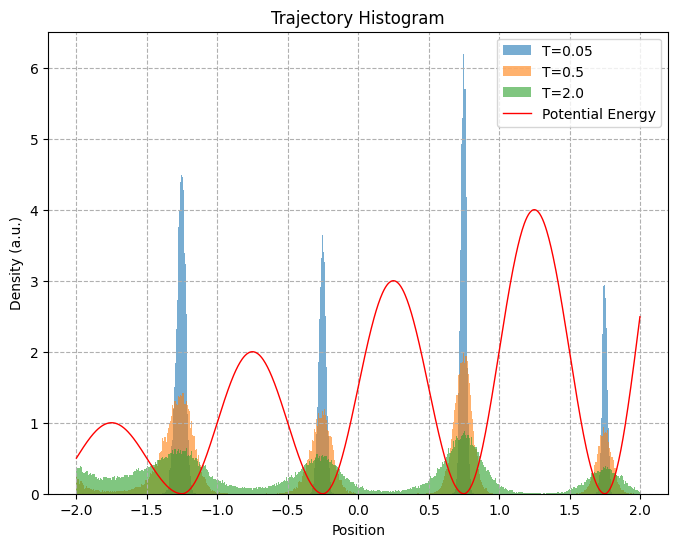

In [422]:
trajectory_histogram(trajectories, n_bins=500)

Text(0, 0.5, 'Position')

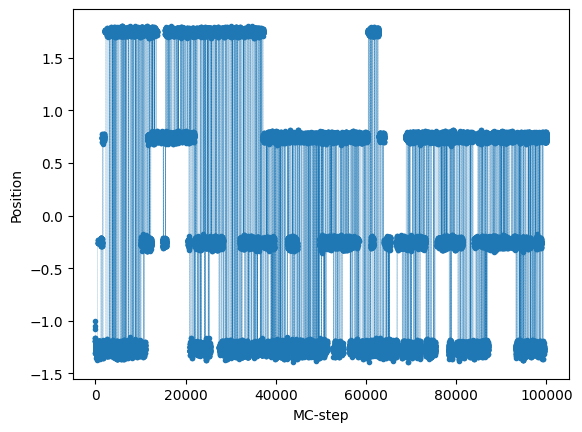

In [424]:
bottom = 0
top = int(1e5)
step = np.arange(bottom, top)

plt.plot(step, trajectories[0,bottom:top], '--.', lw=0.1, label='T=0.05', )
plt.xlabel('MC-step')
plt.ylabel('Position')

# Block averaging for error estimate

Equilibration after 100 steps

/tmp/ipykernel_9378/3546953088.py:17: RuntimeWarning: invalid value encountered in scalar divide
  variance_estimate = variance_estimate = np.sum((averages - average_estimate)**2) / (n_blocks * (n_blocks - 1))


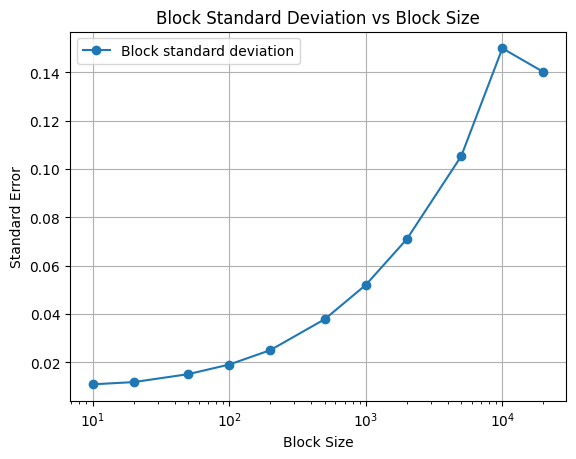

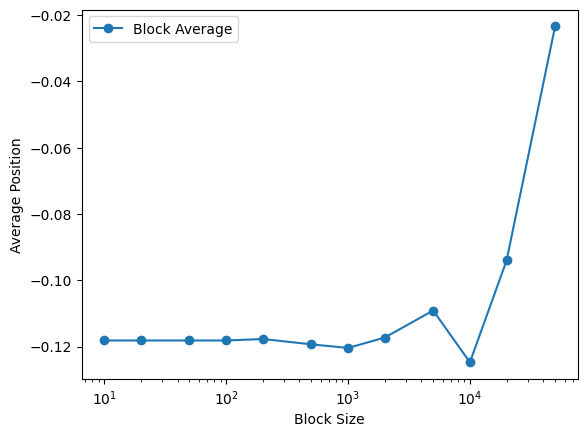

In [ ]:
block_sizes = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 300000]
averages = []
variances = []

equil_trajectory = trajectories.copy()[:, 100:]  # Use the second temperature's trajectory after equilibration


def block_average(trajectory, block_size):
    n_blocks = len(trajectory) // block_size
    averages = np.zeros(n_blocks)
    for i in range(n_blocks):
        block = trajectory[i * block_size:(i + 1) * block_size]
        averages[i] = np.mean(block)

    
    average_estimate = np.mean(averages)
    variance_estimate = variance_estimate = np.sum((averages - average_estimate)**2) / (n_blocks * (n_blocks - 1))
    return average_estimate, variance_estimate

for block_size in block_sizes:
    average, variance = block_average(equil_trajectory[1], block_size) # I have varied the index to get different trajectories
    averages.append(average)
    variances.append(variance)


plt.semilogx(block_sizes, np.sqrt(variances), 'o-', label='Block standard deviation')
plt.legend()
plt.xlabel('Block Size')
plt.ylabel('Standard Error')
plt.title('Block Standard Deviation vs Block Size')
plt.grid()
plt.show()

plt.semilogx(block_sizes, averages, 'o-', label='Block Average')
plt.xlabel('Block Size')
plt.ylabel('Average Position')
plt.legend()
plt.show()

In [427]:
np.mean(trajectories[0, 100:]), np.mean(trajectories[1, 100:]), np.mean(trajectories[2, 100:]), \
np.std(trajectories[0, 100:])/1e3, np.std(trajectories[1, 100:]), np.std(trajectories[2, 100:])

(-0.0389722552890126,
 -0.11817830008195042,
 -0.23157053470169822,
 0.001061003352293671,
 1.0946063320769657,
 1.1251087914624436)

## Computing the std. error manually

In [450]:
number_of_runs = 10
n_steps = int(1e6)
Temperatures = np.array([0.05, 0.5, 2.0])  # k_B = 1

mean_positions = np.zeros((len(Temperatures), number_of_runs))

for i in range(number_of_runs):
    print(f"Run {i+1}/{number_of_runs}")
    energies, mc_acceptance_ratio, swap_acceptance_ratio, trajectories = simulation(n_steps, parallel_tempering=True, x_initial = -1.0)
    mean_positions[:, i] = np.mean(trajectories[:, 100:], axis=1)

print(mean_positions)


Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
[[-0.04460201  0.04926652 -0.1044521   0.00960298 -0.06494139 -0.05801588
   0.10587966  0.0254908  -0.14811148  0.00251466]
 [-0.11655984 -0.02380859 -0.1667408  -0.06109526 -0.13929758 -0.13542199
   0.05129299 -0.04687539 -0.21655333 -0.05209698]
 [-0.24125425 -0.1463232  -0.27723181 -0.17944495 -0.2605742  -0.24459327
  -0.06063675 -0.15780193 -0.33759675 -0.15605246]]


In [454]:
standard_errors = np.std(mean_positions, axis=1, ddof=1) # Use ddof=1 for sample standard deviation

print("Mean Positions:", np.mean(mean_positions, axis=1))
print("Standard Deviations:", standard_errors)

Mean Positions: [-0.02273682 -0.09071568 -0.20615096]
Standard Deviations: [0.07574533 0.0785815  0.08049629]


In [445]:
number_of_runs = 5
n_steps = int(1e5)
Temperatures = np.array([0.05, 0.5, 2.0])  # k_B = 1

mean_positions = np.zeros((len(Temperatures), number_of_runs))

for i in range(number_of_runs):
    print(f"Run {i+1}/{number_of_runs}")
    energies, mc_acceptance_ratio, swap_acceptance_ratio, trajectories = simulation(n_steps, parallel_tempering=True, x_initial = -1.0)
    mean_positions[:, i] = np.mean(trajectories[:, 100:], axis=1)

print(mean_positions)


Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5
[[-0.45888125 -0.25512016 -0.27355272 -0.14118747  0.43689721]
 [-0.50863848 -0.32286196 -0.366231   -0.18489543  0.41448328]
 [-0.59718076 -0.46614842 -0.49072716 -0.2758673   0.38505956]]


In [446]:
standard_errors = np.std(mean_positions, axis=1, ddof=1) # Use ddof=1 for sample standard deviation

print("Mean Positions:", np.mean(mean_positions, axis=1))
print("Standard Deviations:", standard_errors)

Mean Positions: [-0.13836888 -0.19362872 -0.28897282]
Standard Deviations: [0.34116445 0.3590266  0.39420158]


# Diffusion constant

In [466]:
mass = 18/6.022e23/1000
kb = 1.38e-23
T = 300
D = 3e-5

v2 = 3 * kb * T / mass * 1e4

tau = 3*D/v2
print(f"Diffusion time constant (tau):{tau:.2e} s")

Diffusion time constant (tau):2.17e-14 s
